In [1]:
import sys
import argparse
from os.path import join
import os

import pickle
from sklearn.model_selection import train_test_split

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import warnings
import struct
import time
from sklearn import preprocessing

Quantization function for input data

In [2]:
def Quant(Vx, Q, RQM):
    return round(Q * Vx) - RQM


def ListQuant(data_list, quant_bits):
    
    data_min = min(data_list)
    data_max = max(data_list)

    
    Q = ((1 << quant_bits) - 1) * 1.0 / (data_max - data_min)
    RQM = (int)(round(Q*data_min))

    
    quant_data_list = []
    for x in data_list:
        quant_data = Quant(x, Q, RQM)
        quant_data_list.append(quant_data)
    quant_data_list = np.array(quant_data_list)
    return (Q, RQM, quant_data_list)

read and preprocess the data

In [3]:
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

class ReadDataset(Dataset):
    def __init__(self, csv_path):
        self.data_info = pd.read_csv(csv_path, header = None)
        self.ecg_arr = np.asarray(self.data_info.iloc[:, 0]) # read csv filename
        self.label_arr = preprocessing.LabelEncoder().fit_transform(np.asarray(self.data_info.iloc[:, 1])) # read labels     
        self.data_len = len(self.data_info.index) # calculate length
        
    def __getitem__(self, index):
        single_ecg_name = self.ecg_arr[index] # get filename
        
        ecg_raw_data = (open(os.path.join('./simplified_atrial_fibrillation/',single_ecg_name),'rb')).read() # read ecg file
        ecg_data = []
        for t in (range(0,len(ecg_raw_data),4)):
            ecg_data.append((struct.unpack('h',ecg_raw_data[t:t+2]))[0])
            
        ecg_Q, ecg_RQM, ecg_Quantdata = ListQuant(ecg_data,quant_bits=8) #quant to 8 bit
        
        # 1D to 2D, and divide 255
        data_resize=ecg_Quantdata
        data_resize=np.float32((np.trunc(data_resize))/255.0)
        data_resize.resize((5250+12,1),refcheck=False) # padding 12
        #data_resize = np.expand_dims(data_resize, axis = 1)
        data_resize = np.expand_dims(data_resize, axis = 0)
        
        data = data_resize
        
        label = self.label_arr[index]
        return(data, label)
    
    def __len__(self):
        return self.data_len
    

In [4]:
csv_path = "./simplified_atrial_fibrillation/train.csv"
read_dataset = ReadDataset(csv_path)
train_loader = DataLoader(dataset=read_dataset, batch_size=5,shuffle=False)

In [5]:
cnt = 0

for m, (X_train, y_train) in enumerate(train_loader): 
    if cnt>=1: 
        break  
    print((X_train[0]))
    print(np.median(X_train))
    print((X_train.shape))
    print(y_train[0])
    print(X_train[0].shape)
    cnt += 1

tensor([[[0.4157],
         [0.4196],
         [0.4000],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]]])
0.5058824
torch.Size([5, 1, 5262, 1])
tensor(0)
torch.Size([1, 5262, 1])


In [6]:
csv_path = "./simplified_atrial_fibrillation/"
BATCH_SIZE = 512

def Data_Loader(root=csv_path,Batch_Size=BATCH_SIZE):
    
    read_train_dataset = ReadDataset(os.path.join(csv_path,'train.csv'))
    train_loader = DataLoader(dataset=read_train_dataset, batch_size=BATCH_SIZE,shuffle=True)
    
    read_val_dataset = ReadDataset(os.path.join(csv_path,'validation.csv'))
    val_loader = DataLoader(dataset=read_val_dataset, batch_size=BATCH_SIZE,shuffle=True)
    
    read_test_dataset = ReadDataset(os.path.join(csv_path,'test.csv'))
    test_loader = DataLoader(dataset=read_test_dataset, batch_size=BATCH_SIZE,shuffle=True)
    
    return train_loader, val_loader, test_loader
    

train and evaluation functions

In [7]:
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def train_model(CNNmodel,epochs,train_loader,test_loader,criterion,optimizer,Batch_Size=20,print_every = 10, 
                LEARNING_RATE=0.001, lr_reduce=50, verbose=True,plot_results=True):
    
    start_time = time.time()
    batch_size = Batch_Size
    max_trn_batch = 800  # Limits very large datasets
    max_tst_batch = 300
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []
    losses=[]
    
    print('Training for {} epochs...\n'.format(epochs))
    
    for epoch in range(epochs):
        trn_corr = 0
        tst_corr = 0
        trn_loss = 0
        tst_loss = 0
        for m, (X_train, y_train) in enumerate(train_loader): # Run the training batches
            # Limit the number of batches
            if m == max_trn_batch: break
            m+=1

            y_pred = CNNmodel(X_train)  # Apply the model
            loss = criterion(y_pred, y_train)
            
            predicted = torch.max(y_pred.data, 1)[1] # Tally the number of correct predictions
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            optimizer.zero_grad()  # Update parameters
            loss.backward()
            optimizer.step()
            
            trn_loss += loss.item()
            
        train_losses.append(trn_loss)
        train_correct.append(trn_corr*100/(batch_size*m))

        with torch.no_grad():  # Run the testing batches
            for n, (X_test, y_test) in enumerate(test_loader):
                if n == max_tst_batch: break  # Limit the number of batches

                y_val = CNNmodel(X_test)  # Apply the model
                loss = criterion(y_val, y_test)
                tst_loss += loss.item()

                predicted = torch.max(y_val.data, 1)[1]  # Tally the number of correct predictions
                tst_corr += (predicted == y_test).sum()

        test_losses.append(tst_loss)
        test_correct.append(tst_corr*100/(batch_size*n))
        
        if verbose == True and epoch % print_every== 0: 
            print('\n\nEpoch {}/{}: train loss: {:.4f} | acc: {:.4f}%|   validation loss: {:.4f} | acc: {:.4f}%'
                  .format(epoch+1, epochs, trn_loss, trn_corr*100/(batch_size*m), tst_loss, tst_corr*100/(batch_size*n)), end=' ')
        if epoch+1 == epochs:
            print('\n\nFinal Accuracy:{:.4f}%'.format( tst_corr*100/(batch_size*n)))
    
                # adjust the LEARNING_RATE
        if epoch != 0 and epoch % lr_reduce == 0:
            LEARNING_RATE = LEARNING_RATE*0.5
            optimizer = optim.Adam(CNNmodel.parameters(),lr = LEARNING_RATE)
#            for param_group in optimizer.param_groups:
#                param_group['lr'] = LEARNING_RATE
            print('\n\n\nEpoch{}/{}: Set LEARNING_RATE = {:.8f}'.format(epoch+1, epochs, LEARNING_RATE))
    
    
        
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start_time))
    if plot_results == True:
        plt.figure(figsize=(10,10))
        plt.plot(train_losses, label='train loss')
        plt.plot(test_losses, label='validation loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()
        
        plt.figure(figsize=(10,10))
        plt.plot([t for t in train_correct], label='train accuracy')
        plt.plot([t for t in test_correct], label='validation accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.draw()
        
        return CNNmodel

Model architecture

In [8]:
import onnx
import torch
from brevitas.nn import QuantConv2d, QuantIdentity, QuantMaxPool2d, QuantLinear,QuantDropout,QuantReLU,QuantSigmoid
from brevitas.core.quant import QuantType, BinaryQuant, TernaryQuant
from brevitas.core.scaling import ConstScaling
from brevitas.quant import SignedTernaryActPerTensorConst,SignedBinaryActPerTensorConst
import torch.nn as nn
from torch import optim

In [9]:
# no padding for 1D cnn, it may lead to error

class ECG_AF_1D(nn.Module):
    def __init__(self,input_size,num_classes,weight_bit_width,act_bit_width):
        super(ECG_AF_1D,self).__init__()
        
        self.cnn_1 = QuantConv2d(in_channels=input_size,out_channels=6,kernel_size=(9,1),stride=(3,1),
                                padding=(0,0),
                                bias=False,weight_bit_width=weight_bit_width)
        self.bn_1 = nn.BatchNorm2d(6)
        self.relu_1 = QuantReLU(bit_width=act_bit_width)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=(6,1),stride=(6,1))
        
        self.cnn_d2 = QuantConv2d(in_channels=6,out_channels=6,kernel_size=(6,1),
                                 padding=0,groups=6,
                                 bias=False,weight_bit_width=weight_bit_width)
        self.bn_d2 = nn.BatchNorm2d(6)
        self.relu_d2 = QuantReLU(bit_width=act_bit_width)
        self.cnn_2 = QuantConv2d(in_channels=6,out_channels=5,kernel_size=(1,1),
                                padding=0,
                                bias=False,weight_bit_width=weight_bit_width)
        self.bn_2 = nn.BatchNorm2d(5)
        self.relu_2 = QuantReLU(bit_width=act_bit_width)
        
        self.cnn_d3 = QuantConv2d(in_channels=5,out_channels=5,kernel_size=(6,1),
                                 padding=0,groups=5,
                                 bias=False,weight_bit_width=weight_bit_width)
        self.bn_d3 = nn.BatchNorm2d(5)
        self.relu_d3 = QuantReLU(bit_width=act_bit_width)
        self.cnn_3 = QuantConv2d(in_channels=5,out_channels=5,kernel_size=(1,1),
                                padding=0,
                                bias=False,weight_bit_width=weight_bit_width)
        self.bn_3 = nn.BatchNorm2d(5)
        self.relu_3 = QuantReLU(bit_width=act_bit_width)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=(3,1),stride=(3,1)) 
     
        self.cnn_d4 = QuantConv2d(in_channels=5,out_channels=5,kernel_size=(5,1),
                                 padding=0,groups=5,
                                 bias=False,weight_bit_width=weight_bit_width)
        self.bn_d4 = nn.BatchNorm2d(5)
        self.relu_d4 = QuantReLU(bit_width=act_bit_width)
        self.cnn_4 = QuantConv2d(in_channels=5,out_channels=3,kernel_size=(1,1),
                                padding=0,
                                bias=False,weight_bit_width=weight_bit_width)
        self.bn_4 = nn.BatchNorm2d(3)
        self.relu_4 = QuantReLU(bit_width=act_bit_width)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=(6,1),stride=(6,1))
        self.maxpool_5 = nn.MaxPool2d(kernel_size=(3,1),stride=(3,1))
        
        self.drop = QuantDropout(p=0.5)
        self.dense =QuantLinear(5*3,num_classes,bias=False,weight_bit_width=weight_bit_width)
        self.bn_5 = nn.BatchNorm1d(2)
        self.relu_5 = QuantReLU(bit_width=act_bit_width)
        
    def forward(self,x):
        
        x = self.relu_1(self.bn_1(self.cnn_1(x)))
        x = self.maxpool_1(x)
            
        x = self.relu_d2(self.bn_d2(self.cnn_d2(x)))
        x = self.relu_2(self.bn_2(self.cnn_2(x)))

        x = self.relu_d3(self.bn_d3(self.cnn_d3(x)))
        x = self.relu_3(self.bn_3(self.cnn_3(x)))
        x = self.maxpool_3(x)
        
        x = self.relu_d4(self.bn_d4(self.cnn_d4(x)))
        x = self.relu_4(self.bn_4(self.cnn_4(x)))
        x = self.maxpool_4(x)
        x = self.maxpool_5(x)
            
        x = x.view(x.size(0),-1)
        x = self.drop(x)
        x = self.dense(x)
        x = self.bn_5(x)
        x = self.relu_5(x)

        return x

In [27]:
classes = ['atrial_fibrillation', 'sinus']
n_classes = len(classes)

input_size = 1 
num_classes = n_classes
weight_bit_width = 2
act_bit_width = 2

brevitas_model = ECG_AF_1D(input_size=input_size,num_classes=num_classes,
                                    weight_bit_width=weight_bit_width,act_bit_width=act_bit_width)

In [28]:
LEARNING_RATE = 0.01
optimizer = optim.Adam(brevitas_model.parameters(),lr = LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

In [29]:
csv_path = "./simplified_atrial_fibrillation/"
BATCH_SIZE = 64

train_loader, val_loader, test_loader = Data_Loader(root=csv_path,Batch_Size=BATCH_SIZE)

Training for 100 epochs...



Epoch 1/100: train loss: 102.8224 | acc: 47.5647%|   validation loss: 24.9161 | acc: 47.6339% 

Epoch 11/100: train loss: 83.6358 | acc: 72.7263%|   validation loss: 20.8191 | acc: 73.7946% 

Epoch 21/100: train loss: 80.0807 | acc: 74.2780%|   validation loss: 20.2729 | acc: 73.4821% 

Epoch 31/100: train loss: 80.7339 | acc: 72.8233%|   validation loss: 19.7921 | acc: 73.8393% 

Epoch 41/100: train loss: 79.0384 | acc: 74.7306%|   validation loss: 19.2401 | acc: 75.9821% 

Epoch 51/100: train loss: 78.3277 | acc: 74.9030%|   validation loss: 20.1343 | acc: 73.4821% 

Epoch 61/100: train loss: 78.3342 | acc: 74.6875%|   validation loss: 19.6034 | acc: 76.1607% 

Epoch 71/100: train loss: 76.8063 | acc: 76.2177%|   validation loss: 19.2317 | acc: 76.5179% 

Epoch 81/100: train loss: 77.5034 | acc: 75.8728%|   validation loss: 19.7261 | acc: 75.7143% 

Epoch 91/100: train loss: 77.1506 | acc: 76.0345%|   validation loss: 18.9045 | acc: 76.7857% 

Final Accu

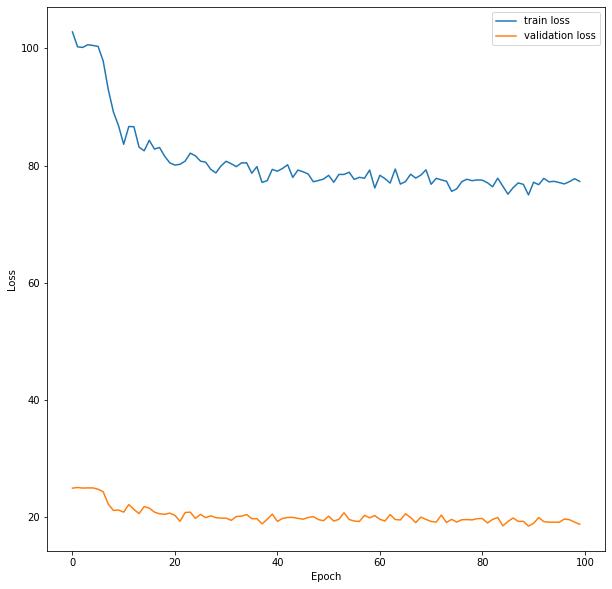

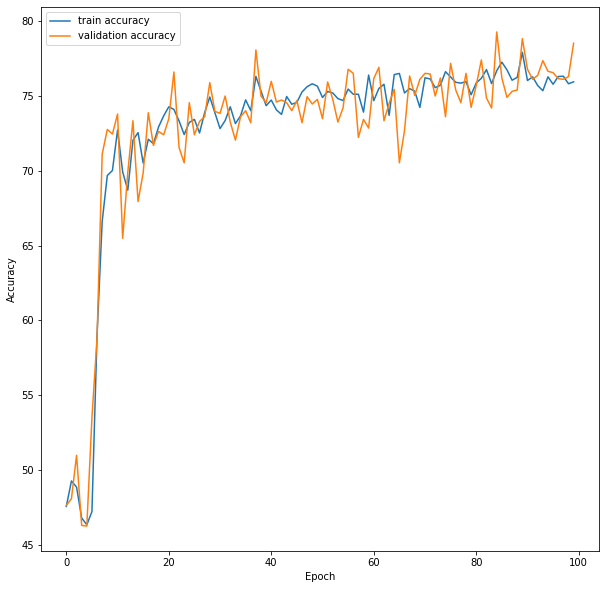

In [30]:
EPOCHS=100
lr_reduce=200
trained_classifier = train_model(CNNmodel=brevitas_model,epochs=EPOCHS,
                                train_loader=train_loader, test_loader=test_loader,
                                criterion = criterion,optimizer = optimizer, 
                                Batch_Size = BATCH_SIZE,print_every = 10, 
                                LEARNING_RATE=LEARNING_RATE, lr_reduce=lr_reduce,
                                verbose=True,plot_results=True)

In [31]:
torch.save(brevitas_model.state_dict(),'./save/brevitas_model_parameter_w2a2_no_padding.pth')

save parameters and export ONNX model

In [32]:
import brevitas.onnx as bo

In [ ]:
export_onnx_path="./save/ECG_test_no_padding.onnx"
input_shape=(1,1,5262,1)
bo.export_finn_onnx(brevitas_model, input_shape, export_onnx_path)

In [34]:
from finn.core.modelwrapper import ModelWrapper
from finn.core.datatype import DataType

In [35]:
model_file="./save/ECG_test_no_padding.onnx"

model=ModelWrapper(model_file)
model.set_tensor_datatype(model.graph.input[0].name, DataType.UINT8) # FINN v0.6
#model.set_tensor_datatype(model.graph.input[0].name, DataType["UINT8"]) # FINN v0.7
model.save(model_file)